In [36]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, add, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np
import os
import math

In [37]:
batch_size = 128
epochs = 200
data_augementation = True
num_classes = 10
subtract_pixel_mean = True

In [38]:
n = 3
depth = n * 6 + 2

In [39]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [40]:
input_shape = x_train.shape[1:]   # shape is (50000, 32, 32, 3)
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/ 255

print(x_train.shape, x_test.shape[0], y_train.shape, y_test.shape)

(50000, 32, 32, 3) 10000 (50000, 1) (10000, 1)


In [41]:
y_train.shape, y_test.shape

((50000, 1), (10000, 1))

In [42]:
# one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [7]:
def resnet_layer(inputs, num_filters = 16, kernel_size = 3, strides = 1, activation = "relu", batch_normalization = True, conv_first = True):
  conv = Conv2D(num_filters,
                kernel_size = kernel_size,
                strides = strides,
                padding = "same",
                kernel_initializer= 'he_normal',
                kernel_regularizer = l2(1e-4))
  x = inputs

  # case for ResNetV1
  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  return x

In [8]:
# ResNet-20. depth = 6n + 2

def resnet_v1(input_shape, depth, num_classes=10):
    " We Have Three Sets Of Residual Blocks"
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (e.g., 20, 32, 44, 56, 110 in [a])')

    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    # input data - Convolution
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # stack 1
    ## Residual Blocks (1)
    for res_block in range(num_res_blocks):
      y = resnet_layer(inputs = x, num_filters = num_filters)
      y = resnet_layer(inputs = y, num_filters = num_filters, activation = None) # post-addition ReLU will be applied
      x = add([x, y])
      x = Activation("relu")(x)

    # stack 2
    ## Transition (1)
    num_filters *= 2
    y = resnet_layer(inputs = x, num_filters = num_filters, strides = 2) # Downsample the feature maps
    y = resnet_layer(inputs = y, num_filters = num_filters, activation = None)
    # Adjust dimensions of x to match those of y using 1x1 convolution
    x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=2, activation=None, batch_normalization=False)
    x = add([x, y])
    x = Activation("relu")(x)

    ## Residual Blocks (2)
    for res_block in range(1, num_res_blocks):
      y = resnet_layer(inputs=x, num_filters=num_filters)
      y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
      x = add([x, y])
      x = Activation('relu')(x)

    # stack 3
    ## Transition (2)
    num_filters *= 2
    y = resnet_layer(inputs=x, num_filters=num_filters, strides=2)
    y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
    x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=2, activation=None, batch_normalization=False)
    x = add([x, y])
    x = Activation('relu')(x)

    ## Residual Blocks (3)
    for res_block in range(1, num_res_blocks):
        y = resnet_layer(inputs=x, num_filters=num_filters)
        y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
        x = add([x, y])
        x = Activation('relu')(x)

    ## Average Pooling
    x = AveragePooling2D(pool_size = 8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation = 'softmax', kernel_initializer='he_normal')(y)
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [20]:
input_shape

(32, 32, 3)

In [21]:
model = resnet_v1(input_shape = input_shape, depth = depth)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 16)           448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 32, 32, 16)           64        ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 32, 32, 16)           0         ['batch_normalization_19

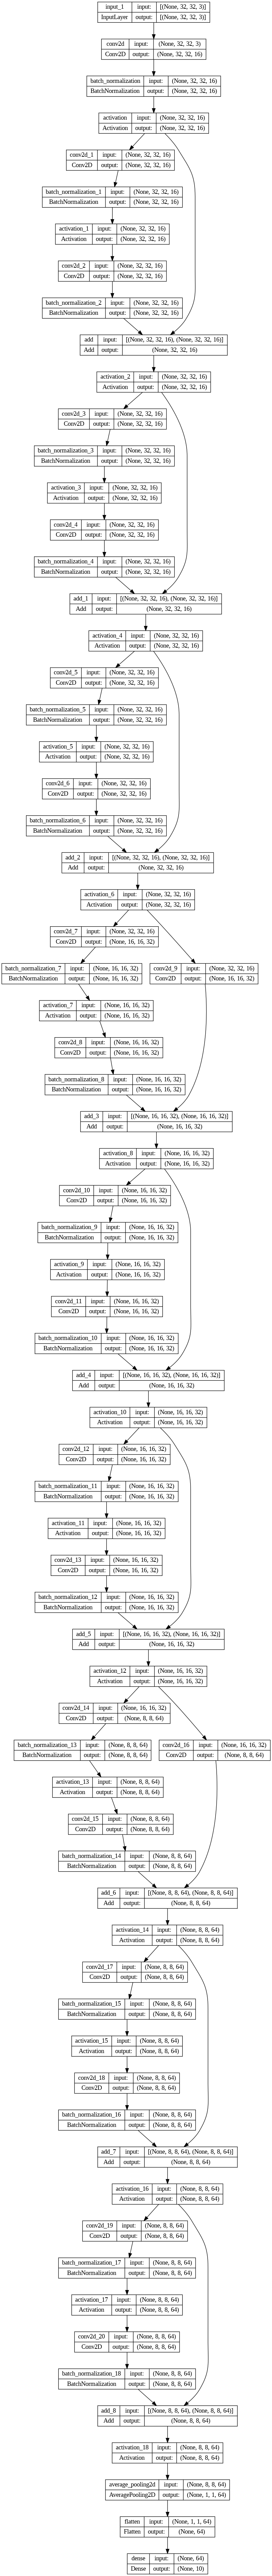

In [11]:
plot_model(model, show_shapes = True)

In [44]:
# Lr Schedule
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 180:
    lr *= 0.5e-3
  elif epoch > 160:
    lr *= 1e-3
  elif epoch > 120:
    lr *= 1e-2
  elif epoch > 80:
    lr *= 1e-1

  print("learning rate", lr)
  return lr

In [45]:
save_dir = os.path.join(os.getcwd(), 'saved_models')

model_name = f'cifar10_ResNet20V1_model' + '.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [43]:
# data augementation
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=0,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)
datagen.fit(x_train)

In [46]:
steps_per_epoch =  math.ceil(len(x_train) / batch_size)
steps_per_epoch

391

In [50]:
x_batch, y_batch = next(datagen.flow(x_train, y_train, batch_size=batch_size))

print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: (128, 32, 32, 3)
y_batch shape: (128, 10)


In [51]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = lr_schedule(0)),
              metrics=['acc'])

model.fit(x = datagen.flow(x_train, y_train, batch_size=batch_size),
          verbose = 1,
          epochs = epochs,
          validation_data=(x_test, y_test),
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)

learning rate 0.001
learning rate 0.001
Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 1.6279 - acc: 0.4651
Epoch 1: val_acc improved from -inf to 0.35860, saving model to /content/saved_models/cifar10_ResNet20V1_model.001.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 98s 91ms/step - loss: 1.6279 - acc: 0.4651 - val_loss: 2.1653 - val_acc: 0.3586 - lr: 0.0010
learning rate 0.001
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.2524 - acc: 0.6050
Epoch 2: val_acc improved from 0.35860 to 0.55200, saving model to /content/saved_models/cifar10_ResNet20V1_model.002.h5
391/391 [==============================] - 33s 84ms/step - loss: 1.2524 - acc: 0.6050 - val_loss: 1.4662 - val_acc: 0.5520 - lr: 0.0010
learning rate 0.001
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.0883 - acc: 0.6664
Epoch 3: val_acc improved from 0.55200 to 0.64730, saving model to /content/saved_models/cifar10_ResNet20V1_model.003.h5
391/391 [==============================] - 34s 86ms/step - loss: 1.0883 - acc: 0.6664 - val_loss: 1.1344 - val_acc: 0.6473 - lr: 0.0010
learning rate 0.001
Epoch 4/200
391/391 [==============================] - ETA: 0s - loss: 0.9709 - acc: 0.7090
Epoch 4: val_a

In [53]:
from tensorflow.keras.models import load_model
final_model = load_model('/content/saved_models/cifar10_ResNet20V1_model.141.h5')
final_model.evaluate(x_test, y_test, batch_size = batch_size, verbose=0)

[0.5168724656105042, 0.906499981880188]